In [144]:
import pandas as pd
import pandasql as psql
import time
import math
import os
import role_classification_functions as rcf
import seaborn as sns
pd.options.display.max_columns = None

fname=os.getcwd()+'\\database'+'\\Souporsecret_4_2.csv'
df_soup=pd.read_csv(fname)
df_soup1=df_soup[df_soup['queue'].isin(['5v5 Draft Pick games','5v5 Ranked Flex games','5v5 Ranked Solo games','5v5 Blind Pick games','Clash games'])]
df_soup2=rcf.new_lane_classification(df_soup1,cleaning=True)
print(rcf.score_error(df_soup2))
df=df_soup2[df_soup2['role_error_flag'] == False].copy()
print(rcf.score_error(df))
print(len(df))
df.head(3)

4
0
25990


,minute,participantId,totalGold,level,xp,minionsKilled,jungleMinionsKilled,gameId,queue,teamId,win,champion_name,role,lane,summonerName,pos_x,pos_y,spell0,spell1,item0,item1,item2,item3,item4,item5,pos_lane,jungle_flag,support_flag,final_role,role_error_flag
0,0,7,500,1,0,0,0,3849016581,5v5 Draft Pick games,Red,False,Darius,SOLO,TOP,Boss 0f This Gym,14180,14271,Flash,Teleport,Thornmail,Stridebreaker,Plated Steelcaps,Sterak's Gage,Dead Man's Plate,Caulfield's Warhammer,TOP,False,False,TOP,False
1,1,7,500,1,0,0,0,3849016581,5v5 Draft Pick games,Red,False,Darius,SOLO,TOP,Boss 0f This Gym,6767,11479,Flash,Teleport,Thornmail,Stridebreaker,Plated Steelcaps,Sterak's Gage,Dead Man's Plate,Caulfield's Warhammer,TOP,False,False,TOP,False
2,2,7,584,1,181,3,0,3849016581,5v5 Draft Pick games,Red,False,Darius,SOLO,TOP,Boss 0f This Gym,2170,12608,Flash,Teleport,Thornmail,Stridebreaker,Plated Steelcaps,Sterak's Gage,Dead Man's Plate,Caulfield's Warhammer,TOP,False,False,TOP,False


In [145]:
''' @Params
    df = name of dataframe
    name = summoner name to mark
    Returns dataframe with column homeTeam, which is True if the team contains the entered summoner name. name is not case sensitive
'''
def mark_summoner(df, name):
    name_lower = name.lower()
    df['summonerName']=df['summonerName'].str.lower()
    df_1 = df[['gameId','summonerName','teamId']].copy().drop_duplicates()
    df_2=df_1[df_1['summonerName']==name_lower].copy()
    df_2['homeTeam'] = [True for i in range(len(df_2))]
    #df_2.drop(['summonerName'],inplace=True)

    df_3=df.merge(df_2[['gameId','teamId','homeTeam']],how='left',on = ['gameId','teamId'])
    df_3.fillna(False,inplace=True)
    return df_3

In [169]:
''' @Params
    df = name of dataframe
    name = summoner name **NOT USED YET
    minutes = time  to see gold diff
    ROLE = position: BOT_CARRY, SUPPORT, MIDDLE, JUNGLE, TOP
'''
def gold_diff_x(df, name, minutes=[10], role="BOT_CARRY"):
    
    df_1=mark_summoner(df,name)
    #print(len(df_1))
 
    df_out = pd.DataFrame()
    for minute, i in zip(minutes,range(len(minutes))):
        df_2=df_1[df_1['minute']==minute]
        prep=df_2[['gameId','minute','homeTeam','summonerName','champion_name','totalGold','minionsKilled','jungleMinionsKilled','final_role']].copy()

        home=prep[(prep['summonerName']==name.lower()) & (prep['homeTeam']==True) & (prep['final_role']==role)].copy()
        away=prep[(prep['homeTeam']==False) & (prep['final_role']==role) ].copy()
        
        df_versus=home.merge(away, on = ["gameId","minute"])
        gd_col='goldDiff'+str(minute)
        csd_col='csDiff'+str(minute)
        df_versus[gd_col]=df_versus['totalGold_x'] - df_versus['totalGold_y'] 
        df_versus[csd_col]=df_versus['minionsKilled_x'] + df_versus['jungleMinionsKilled_x'] - df_versus['minionsKilled_y'] - df_versus['jungleMinionsKilled_y'] 
        df_stats=df_versus[['gameId', 'champion_name_x','champion_name_y', gd_col, csd_col]]

        #combine stats for each minute
        if i==0:
            df_out=df_out.append(df_stats)
        else:
            df_out=df_out.merge(df_stats, on=['gameId', 'champion_name_x','champion_name_y'],how="left")

    return df_out

    #Returns summary of output of gold_diff function
def summarize_stats(df):
    stats_list=[]
    for champ in df['champion_name_x'].drop_duplicates():
        champ_row = {}
        champ_df=df[df['champion_name_x']==champ]
        champ_row['champion']=champ
        champ_row['games']=len(champ_df)
        for column in list(champ_df.columns[3:]):
            champ_row[column]=champ_df[column].mean(skipna=True)
        stats_list.append(champ_row)

    return pd.DataFrame(stats_list)


In [174]:
display(gold_diff_x(df,"AerialBlast",minutes=[10, 15, 20, 30],role="BOT_CARRY") )
display(summarize_stats(gold_diff_x(df,"AerialBlast",minutes=[10, 15, 20, 30],role="BOT_CARRY") ).round(0))
#summarize_stats( gold_diff_x(df,"SouporSecret",minutes=[10, 15, 20],role="SUPPORT")) 

,gameId,champion_name_x,champion_name_y,goldDiff10,csDiff10,goldDiff15,csDiff15,goldDiff20,csDiff20,goldDiff30,csDiff30
0,3847601269,Draven,Tristana,-1246,-8,-451,-19,-1106.0,-26.0,-2124.0,-42.0
1,3847507333,Sivir,Kaisa,5,5,330,14,312.0,5.0,NaN,NaN
2,3844020687,Sivir,Ezreal,658,2,1337,3,1704.0,22.0,2037.0,25.0
3,3843896927,Sivir,Draven,-933,-7,-2738,-23,NaN,NaN,NaN,NaN
4,3843322544,Sivir,Ashe,-1085,7,241,11,-321.0,-2.0,367.0,40.0
5,3843193543,Sivir,Senna,-369,53,-1098,79,-731.0,77.0,-420.0,94.0
6,3842743671,MissFortune,Varus,869,32,2375,34,3279.0,33.0,NaN,NaN
7,3842657060,Draven,Jhin,-385,-1,-102,-17,101.0,3.0,2173.0,48.0
8,3840383384,Draven,Jinx,198,-6,138,-14,198.0,-12.0,747.0,-49.0
9,3834857956,Kaisa,Xayah,399,14,-578,9,-395.0,-10.0,-780.0,-34.0


,champion,games,goldDiff10,csDiff10,goldDiff15,csDiff15,goldDiff20,csDiff20,goldDiff30,csDiff30
0,Draven,3,-478.0,-5.0,-138.0,-17.0,-269.0,-12.0,265.0,-14.0
1,Sivir,5,-345.0,12.0,-386.0,17.0,241.0,26.0,661.0,53.0
2,MissFortune,1,869.0,32.0,2375.0,34.0,3279.0,33.0,NaN,NaN
3,Kaisa,15,419.0,4.0,783.0,8.0,1278.0,13.0,547.0,-13.0
4,Tristana,15,306.0,-2.0,555.0,-1.0,1259.0,3.0,1333.0,5.0
5,Jhin,1,-488.0,9.0,-515.0,1.0,-1165.0,-5.0,-1387.0,-6.0
6,Jinx,1,761.0,-5.0,784.0,-6.0,414.0,13.0,-852.0,21.0
7,Caitlyn,3,230.0,14.0,719.0,19.0,1259.0,19.0,68.0,17.0
8,Senna,3,441.0,16.0,486.0,14.0,1136.0,30.0,NaN,NaN


In [ ]:
mike_supp=gold_diff_x(df,"SouporSecret",minutes=[10, 15],role="SUPPORT")

In [148]:
kev_adc=gold_diff_x(df,"AerialBlast",minutes=[10, 15])
stats_list=[]
for champ in kev_adc['champion_name_x'].drop_duplicates():
    champ_row = {}
    champ_df=kev_adc[kev_adc['champion_name_x']==champ]
    champ_row['champion']=champ
    champ_row['games']=len(champ_df)
    for column in list(champ_df.columns[3:]):
        champ_row[column]=int(champ_df[column].mean())
    stats_list.append(champ_row)
stats_list
stats_df = pd.DataFrame(stats_list)
stats_df

,champion,games,goldDiff10,csDiff10,goldDiff15,csDiff15
0,Draven,3,-477,-5,-138,-16
1,Sivir,5,-344,12,-385,16
2,MissFortune,1,869,32,2375,34
3,Kaisa,15,418,4,783,8
4,Tristana,15,305,-1,554,-1
5,Jhin,1,-488,9,-515,1
6,Jinx,1,761,-5,784,-6
7,Caitlyn,3,230,14,719,19
8,Senna,3,441,16,486,13


In [149]:
mike_supp=gold_diff_x(df,"SouporSecret",minutes=[10, 15],role="SUPPORT")
stats_list=[]
for champ in mike_supp['champion_name_x'].drop_duplicates():
    champ_row = {}
    champ_df=mike_supp[mike_supp['champion_name_x']==champ]
    champ_row['champion']=champ
    champ_row['games']=len(champ_df)
    for column in list(champ_df.columns[3:]):
        champ_row[column]=int(champ_df[column].mean())
    stats_list.append(champ_row)
stats_list
stats_df = pd.DataFrame(stats_list)
stats_df

,champion,games,goldDiff10,csDiff10,goldDiff15,csDiff15
0,Thresh,9,-145,5,19,6
1,Alistar,3,-73,3,-209,6
2,Zyra,7,518,-8,818,-11
3,Leona,8,-70,5,-103,7
4,Blitzcrank,1,-61,10,-900,18
5,Seraphine,27,299,-4,659,-5
6,Karma,2,-565,-8,-685,-8
7,Morgana,1,-142,5,180,10
8,Bard,2,646,-4,879,-4
9,Nautilus,1,18,10,-340,14


47  games, 
231 avg gold diff


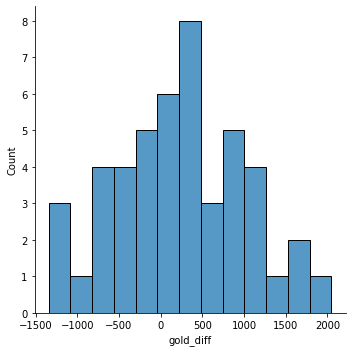

In [6]:
sns.displot(df_test_10.gold_diff, bins =13)
print(len(kev_adc_gold_10), " games, ")
print(int(kev_adc_gold_10.mean()), "avg gold diff")

46  games, 
518 avg gold diff


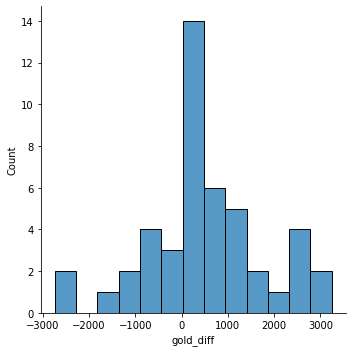

In [33]:
sns.displot(kev_adc_gold_15, bins = 13)
print(len(kev_adc_gold_15), " games, ")
print(int(kev_adc_gold_15.mean()), "avg gold diff")

In [34]:
df_test_10_m=gold_diff_x(df,"Souporsecret",minutes=[10],role="SUPPORT")
df_test_10_m['gold_diff']=df_test_10_m['totalGold_x'] - df_test_10_m['totalGold_y'] 

m_supp_gold_10 = df_test_10_m['gold_diff']
print(len(m_supp_gold_10))
df_test_15_m=gold_diff_x(df,"Souporsecret",minutes=[15],role="SUPPORT")
df_test_15_m['gold_diff']=df_test_15_m['totalGold_x'] - df_test_15_m['totalGold_y'] 

m_supp_gold_15 = df_test_15_m['gold_diff']
print(len(m_supp_gold_15))
df_test_10_m

61
61


,gameId,minute,homeTeam_x,summonerName_x,champion_name_x,totalGold_x,minionsKilled_x,final_role_x,homeTeam_y,summonerName_y,champion_name_y,totalGold_y,minionsKilled_y,final_role_y,gold_diff
0,3849016581,10,True,souporsecret,Thresh,2062,14,SUPPORT,False,thankstothebay,Nami,2779,0,SUPPORT,-717
1,3847601269,10,True,souporsecret,Alistar,1870,9,SUPPORT,False,ethidium bromide,Blitzcrank,2441,13,SUPPORT,-571
2,3847507333,10,True,souporsecret,Zyra,2815,6,SUPPORT,False,atui,Warwick,1982,14,SUPPORT,833
3,3844648489,10,True,souporsecret,Leona,2857,16,SUPPORT,False,luoj bu wan adc,Senna,2395,12,SUPPORT,462
4,3844663230,10,True,souporsecret,Zyra,3165,7,SUPPORT,False,c9zed,Rell,1933,8,SUPPORT,1232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,3775995746,10,True,souporsecret,Seraphine,2883,6,SUPPORT,False,good buddy coco,Nautilus,1985,12,SUPPORT,898
57,3775949746,10,True,souporsecret,Thresh,3065,11,SUPPORT,False,nob1e,Maokai,2236,10,SUPPORT,829
58,3766805551,10,True,souporsecret,Seraphine,3671,10,SUPPORT,False,noca toca,Sett,2288,15,SUPPORT,1383
59,3766810793,10,True,souporsecret,Leona,1955,12,SUPPORT,False,kanna kamuı,Nautilus,1969,13,SUPPORT,-14


61  games, 
131 avg gold diff


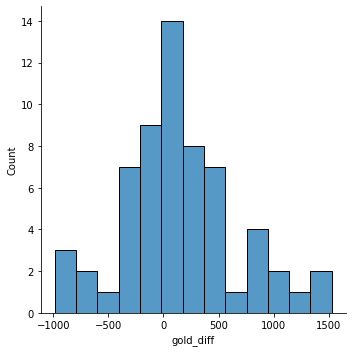

In [35]:
sns.displot(m_supp_gold_10, bins = 13)
print(len(m_supp_gold_10), " games, ")
print(int(m_supp_gold_10.mean()), "avg gold diff")

61  games, 
324 avg gold diff


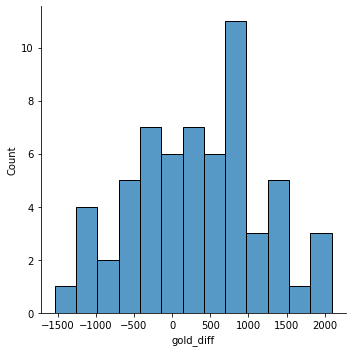

In [36]:
sns.displot(m_supp_gold_15, bins = 13)
print(len(m_supp_gold_15), " games, ")
print(int(m_supp_gold_15.mean()), "avg gold diff")